# Mesh refinement & deformation

Uniform mesh:
 hmin, hmax, ncells = 0.10, 0.14, 200
After refining:
 hmin, hmax, ncells = 0.02, 0.14, 910
After deforming:
 hmin, hmax, ncells = 0.05, 0.33, 200


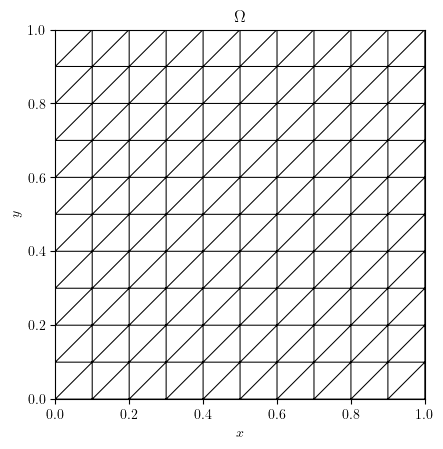

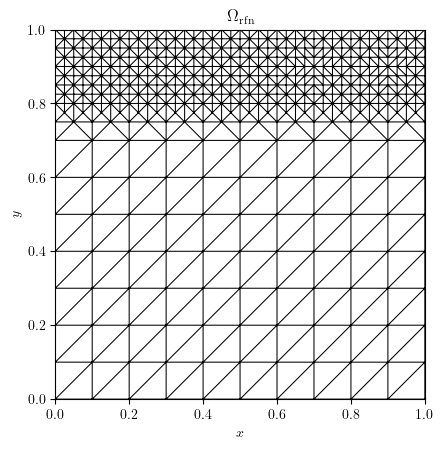

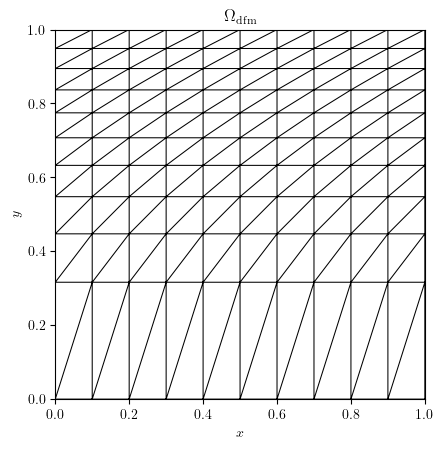

: 

In [ ]:
from typing import Callable
import numpy as np
from lucifex.mesh import rectangle_mesh, refine, deform
from lucifex.utils import cell_sizes, n_entities, cross_section
from lucifex.viz import plot_mesh, plot_colormap, plot_line


def power_transform(
    s: float,
    Lx: float | tuple[float, float],
) -> Callable[[np.ndarray], np.ndarray]:
    """
    `ζ(x) = (x - x₋) / (x₊ - x₋) –> ((x - x₋) / (x₊ - x₋))ˢ`
    """
    if isinstance(Lx, float):
        Lx = (0.0, Lx)
    x_min, x_max = Lx
    Lx = x_max - x_min

    return lambda x: x_min + Lx * ((x - x_min) / Lx) ** s


Lx = 1.0
Ly = 1.0
cell = 'right'
name = 'Omega'
mesh = rectangle_mesh(Lx, Ly, 10, 10, name, cell)
n_cells = n_entities(mesh, 2)
hmin = np.min(cell_sizes(mesh, 'hmin'))
hmax = np.max(cell_sizes(mesh, 'hmax'))

marker = lambda x: x[1] > 0.75 * Ly
mesh_refined = refine(mesh, marker, n_stop=2, name='OmegaRfn')
n_cells_refined = n_entities(mesh_refined, 2)
hmin_refined = np.min(cell_sizes(mesh_refined, 'hmin'))
hmax_refined = np.max(cell_sizes(mesh_refined, 'hmax'))

mesh_deformed = deform(mesh, power_transform(0.5, Ly), index=1, name='OmegaDfm')
n_cells_deformed = n_entities(mesh_deformed, 2)
hmin_deformed = np.min(cell_sizes(mesh_deformed, 'hmin'))
hmax_deformed = np.max(cell_sizes(mesh_deformed, 'hmax'))

plot_mesh(mesh, title='$\Omega$')
print(f'Uniform mesh:\n hmin, hmax, ncells = {hmin:.2f}, {hmax:.2f}, {n_cells}')

plot_mesh(mesh_refined, title="$\Omega_{\mathrm{rfn}}$")
print(f'After refining:\n hmin, hmax, ncells = {hmin_refined:.2f}, {hmax_refined:.2f}, {n_cells_refined}')

plot_mesh(mesh_deformed, title="$\Omega_{\mathrm{dfm}}$")
print(f'After deforming:\n hmin, hmax, ncells = {hmin_deformed:.2f}, {hmax_deformed:.2f}, {n_cells_deformed}')

## Example: reaction-diffusion equation with a boundary layer

$$\varepsilon\nabla^2u=u$$

$$\Omega = [0, L_x] \times [0, L_y]$$

$$u(x,y=L_y)=1$$

$$u(x,y=0)=u(x=0,y)=u(x=L_x,y)=0$$

There will be a boundary layer of size $\mathcal{O}(\varepsilon^{1/2})$ below the upper boundary.

In [ ]:
from ufl import Form, dx, inner, grad, TestFunction, TrialFunction
from lucifex.fem import SpatialFunction as Function, SpatialConstant as Constant
from lucifex.solver import bvp, BoundaryConditions
from lucifex.pde.transport_steady import reaction_diffusion


eps_value = 1e-3
bcs = BoundaryConditions(
    ("dirichlet", lambda x: x[1] - Ly, 1.0),
    ("dirichlet", lambda x: x[1], 0.0),  
    ("dirichlet", lambda x: x[0] - Lx, 0.0),  
    ("dirichlet", lambda x: x[0], 0.0),  
)

eps = Constant(mesh, eps_value)
bl = np.sqrt(eps_value)

u = Function((mesh, 'P', 1), name='u')
u_solver = bvp(reaction_diffusion, bcs)(u, eps)
u_solver.solve()

epsRfn = Constant(mesh_refined, eps_value)
uRfn = Function((mesh_refined, 'P', 1), name='uRfn')
uRfn_solver = bvp(reaction_diffusion, bcs)(uRfn, epsRfn)
uRfn_solver.solve()

epsDfm = Constant(mesh_deformed, eps_value)
uDfm = Function((mesh_deformed, 'P', 1), name='uDfm')
uDfm_solver = bvp(reaction_diffusion, bcs)(uDfm, epsDfm)
uDfm_solver.solve()

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '$u_{\\mathrm{dfm}}$'}, xlabel='$x$', ylabel='$y$'>)

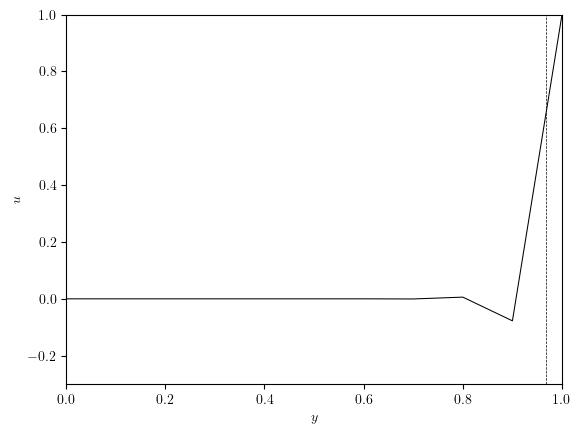

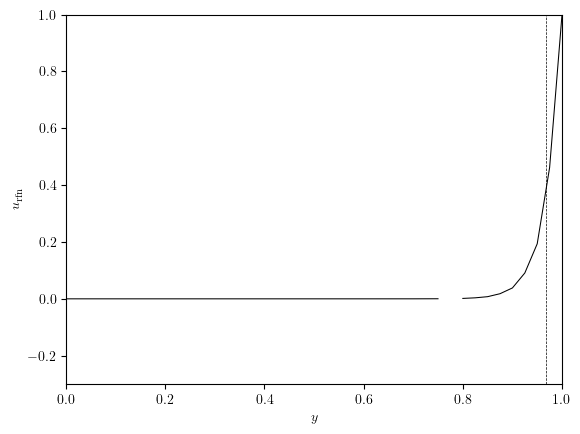

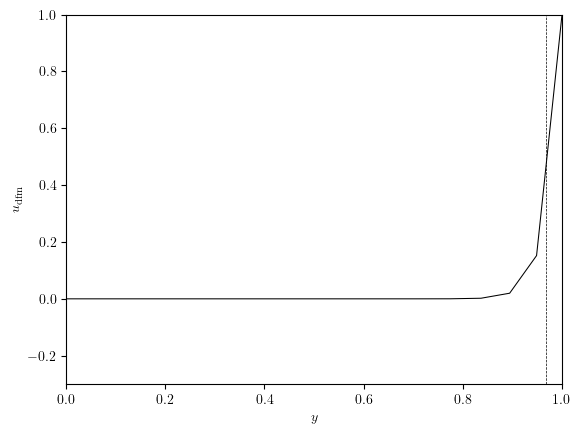

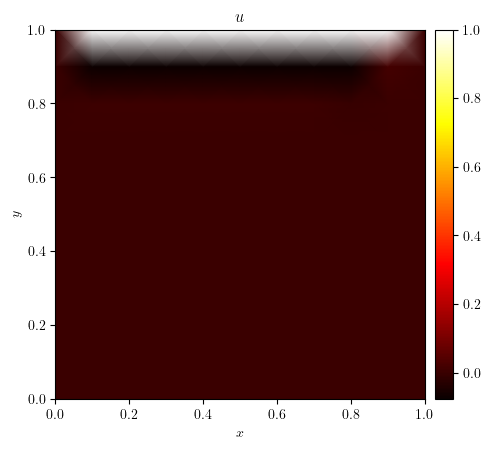

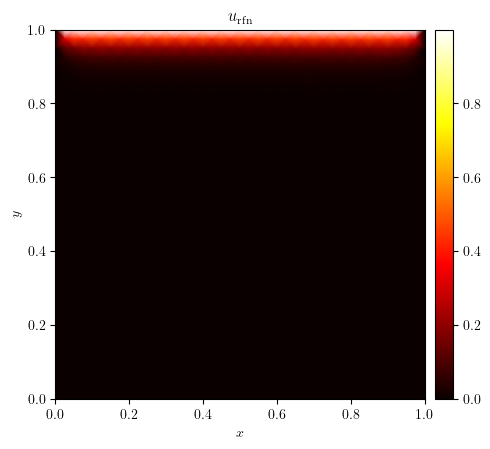

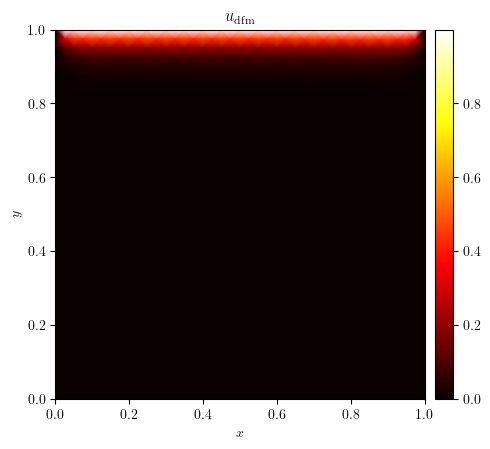

: 

In [ ]:
y_lims = (-0.3, 1.0)
plot_boundary_layer = lambda ax: [
    ax.vlines([Ly - bl], *y_lims, color='black', ls='dashed', lw=0.5),
    ax.set_ylim(*y_lims)
]

y_axis, u_cross, y_value = cross_section(u, 'x', 0.5)
fig, ax = plot_line((y_axis, u_cross), x_label='$y$', y_label='$u$')
plot_boundary_layer(ax)

yRfn_axis, uRfn_cross, yRfn_value = cross_section(uRfn, 'x', 0.5)
fig, ax = plot_line((yRfn_axis, uRfn_cross), x_label='$y$', y_label="$u_{\mathrm{rfn}}$")
plot_boundary_layer(ax)

yDfm_axis, uDfm_cross, yDfm_value = cross_section(uDfm, 'x', 0.5)
fig, ax = plot_line((yDfm_axis, uDfm_cross), x_label='$y$', y_label="$u_{\mathrm{dfm}}$")
plot_boundary_layer(ax)

plot_colormap(u, title='$u$')
plot_colormap(uRfn, title="$u_{\mathrm{rfn}}$")
plot_colormap(uRfn, title="$u_{\mathrm{dfm}}$")